## TREASMO Quick Start

In [1]:
import os
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning, NumbaWarning
import warnings
warnings.simplefilter('ignore', category=NumbaWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import muon as mu
# Import a module with ATAC-seq-related functions
from muon import atac as ac

from matplotlib import pyplot as plt
import seaborn as sns

sc.set_figure_params(
    scanpy=True, dpi_save=600, vector_friendly=True, format="pdf",
    facecolor=(1.0, 1.0, 1.0, 0.0), transparent=False
)

from matplotlib import rcParams
rcParams["savefig.bbox"] = "tight"
rcParams["savefig.dpi"] = 600

/home/chaozhong/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Introduction
In the quick start tutorial, we will use a down-sampled **10X Multiome HSPC dataset** to demonstrate the analysis pipeline and all utilities in the **TREASMO toolkit**.

#### Data Availability
Data can be downloaded from the [Google Drive](www.google.com)

#### Load in the 4 modules of TREASMO

In [2]:
import treasmo.tl
import treasmo.core
import treasmo.ds
import treasmo.pl

/home/chaozhong/miniconda3/lib/python3.10/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


### Data Preparation
#### 1. Input
Here we will use preprocessed multiome data. If you are working on your own dataset, please go through the **checklist below**.  
- The dataset is in **MuData** object  
- The MuData contains **two modules**: scRNA-seq and scATAC-seq. The **mod names** is needed, here we have 'rna' and 'atac'
- The two modules contains processed matrix **X**:
    - scRNA-seq: library-size corrected and log-transformed
    - scATAC-seq: log(TF) * log(IDF) trasformed
- The MuData object has neighborhood saved in uns['connectivities'], it can from Muon WNN results, or from either modality KNN graph. (Required to quantify the correlation strength)
- The MuData object has cluster labels saved in obs (Required to perform any group comparison)
- The MuData object has trajectory pseudotime saved in obs (Required to perform trajectory-based analysis)

In [3]:
mudata = mu.read('data/HSPC_toyexample.h5mu')
#mudata

#### 2. Calculate feature sparsity per group
We found that feature sparsity influences the correlation strength analysis, and using it as a quality control in results will help filter false positives.  
Here we run **tl.feature_sparsity( )**, ``group_by`` is a dict  
- **keys**: the module names  
- **values** corresponding obs column name containing cluster labels

In [4]:
mudata = treasmo.tl.feature_sparsity(mudata, group_by={'rna':'annotation',
                                                       'atac':'annotation'})

#### 3. Prepare gene-peak pairs Data Frame
TREASMO computes the single-cell correlation strength for all given gene-peak pairs.  
To help prepare such pairs, TREASMO has two functions:
- **tl.peaks_within_distance**: pairs the gene and its nearby peaks within a genome range. (See example below)
- **tl.TFBS_match**: match TF with peaks locating within its binding sites.

In [5]:
genes = mudata.mod['rna'].var_names
peaks = mudata.mod['atac'].var_names
upstream, downstream = 50000, 0
ref_gtf_fn = '../data/Homo_sapiens.GRCh38.104.GeneLoc.Tab.txt'

In [6]:
pairsDF = treasmo.tl.peaks_within_distance(genes, peaks, # genes and peaks names to include
                                           upstream, downstream, # define the genome range, upstream of TSS and downstream of TTS
                                           no_intersect=True, # if peak within the range lies in another gene body, remove the peak or not
                                           ref_gtf_fn, # reference GTF file path
                                           # see example at https://github.com/ChaozhongLiu/TREASMO/tree/main/replication/data/Homo_sapiens.GRCh38.104.GeneLoc.Tab.txt
                                           id_type='Ensembl', # gene ID column name in GTF file 
                                           split_symbol=[':','-']) # delimiter connecting chromosom and position in ATAC-seq peak ID

Remove nearby peaks if it lies on the gene body or promoter regions of other genes.


In [7]:
print("Number of pairs: ",pairsDF.shape[0])
print("Number of genes: ",len(pairsDF['Gene'].unique()))
print("Number of peaks: ",len(pairsDF['Peak'].unique()))

Number of pairs:  1319
Number of genes:  81
Number of peaks:  1314


### Core function - Quantifying single-cell gene-peak correlation strength
The core function of TREASMO is to quantitatively infer specific gene-peak correlation in each cell.  
**core.Local_L** calculates the correlation strength matrix, save it in uns['Local_L'];  
**core.Global_L** calculates the mean of all cell's cor strength. It functions the same as Pearson's correlation.

In [8]:
pairsDF = treasmo.core.Global_L(mudata, pairsDF, # Input MuData and gene-peak pairs Data Frame
                                mods=['rna','atac'], # mod names in MuData
                                permutations=0, # This is the permutation-based significant test, set 0 if not needed
                                seed=1, # random seed to make the results replicable
                                max_RAM=72) # maximum memory usage

Calculating KNN graph-based global correlation...
Finished calculating correlation. 0.390s past


/home/chaozhong/miniconda3/lib/python3.10/site-packages/treasmo/lee_vec.py:62: RuntimeWarning: invalid value encountered in matmul
  self.ctc = self.connectivity.T @ self.connectivity


In [9]:
mudata = treasmo.core.Local_L(mudata, # Input MuData
                              genes=pairsDF['Gene'].tolist(), # Input gene list
                              peaks=pairsDF['Peak'].tolist(), # Input peak list
                              mods=['rna','atac'], # mod names in MuData
                              rm_dropout=False, # if True, zero the strength index when derived from features with dropout values
                              seed=1, max_RAM=72)

Inferring KNN graph-based local correlation...
Following changes made to the AnnData object:
	KNN graph-based local correlation results saved in uns['Local_L']
	Gene-peak pair names saved in uns['Local_L_names']
Finished Inferring local correlation. 0.243s past


### Downstream Analysis
#### 1. Find regulatory markers among groups
TREASMO provides several functions to perform statistical test that compares the gene-peak correlation among groups.
- **ds.FindAllMarkers**: one vs rest test, find markers in each cluster and return the result
- **ds.FindMarkers**: one vs one test, compare user provided two groups
- **ds.FindPathMarkers**: one vs one test, compare all pairs of groups with user provided clisters. (Usually along a trajectory path)

In [10]:
MarkerDf = treasmo.ds.FindAllMarkers(mudata, ident='annotation',
                                     mods=['rna','atac'],
                                     corrct_method='bonferroni', seed=1)

Performing statistical test for correlation differences among identities...
Completed! 9.31s past.


Next, **ds.MarkerFilter** filters the results based on user defined cutoffs, returns the filtered results, and plot the volcano plot.

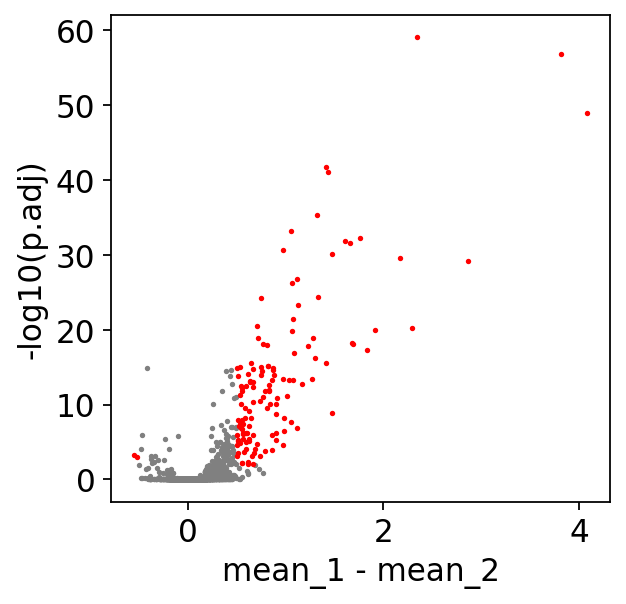

In [11]:
MarkerDf_filt = treasmo.ds.MarkerFilter(MarkerDf,
                                        mean_diff=0.5, # minimum mean difference between two groups
                                        min_pct_rna=0.1, # percentage of cells that express the gene as sparsity cutoff
                                        min_pct_atac=0.05, # percentage of cells that have the peak as sparsity cutoff
                                        p_cutoff=1e-2, # p-value cutoff
                                        plot=True) # plot volcano or not

**Visualization**  
**pl.LocalCor_Heatmap** plots the clustered (or not) correlation strength heatmap

/home/chaozhong/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


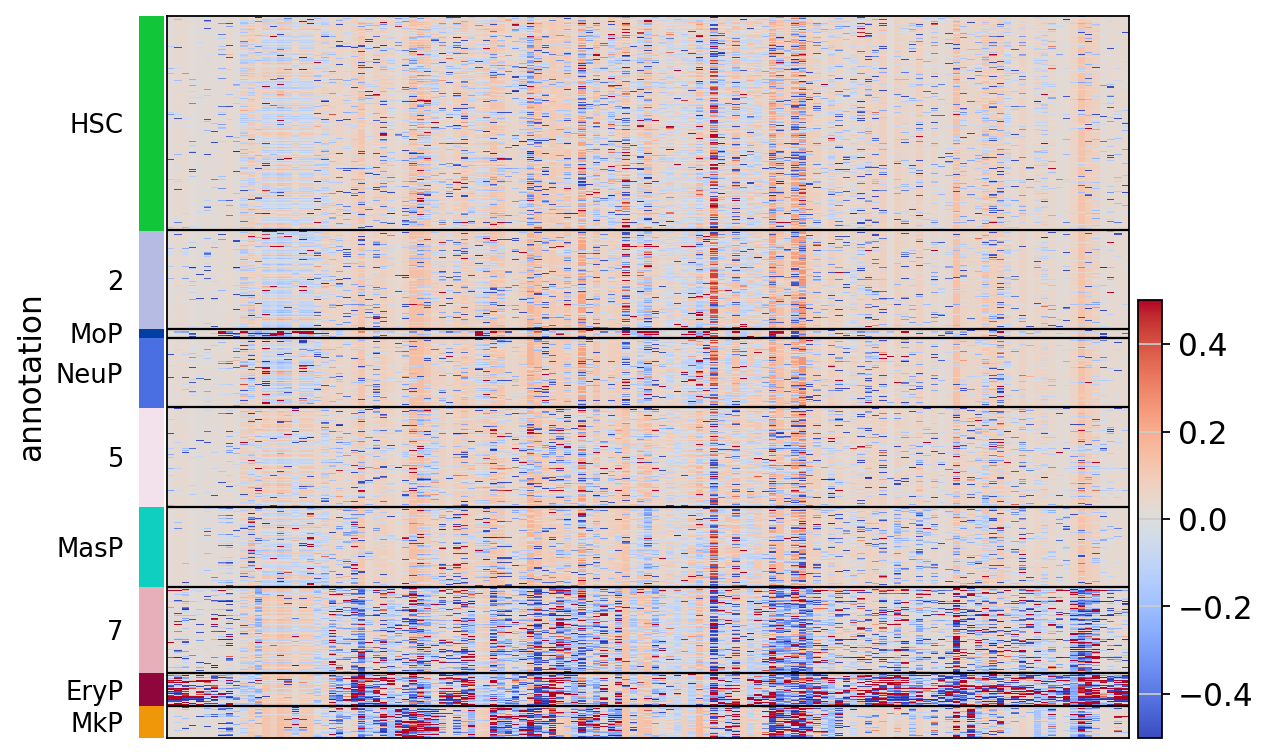

In [12]:
treasmo.pl.LocalCor_Heatmap(mudata,
                            pairs=np.unique(MarkerDf_filt['name']), # which pairs to plot
                            cluster=True, # cluster pairs or not
                            groupby='annotation', # group cells by the ident
                            cmap='coolwarm', # color pallette
                            vmin=-0.5, vmax=0.5) # color value range
                            # you can alos pass any other parameters to sc.pl.heatmap()

#### 2. Detect trajectory dynamics along user defined path
The regulation dynamics encompass a more intricate process than mere comparisons between groups of cells. It represents a continuous and ever-changing phenomenon.  
To achieve so, we run **ds.FindPathDynamics** to detect highly-variable gene-peak pairs along a user defined path.

Empty bins removed. 92 bins left


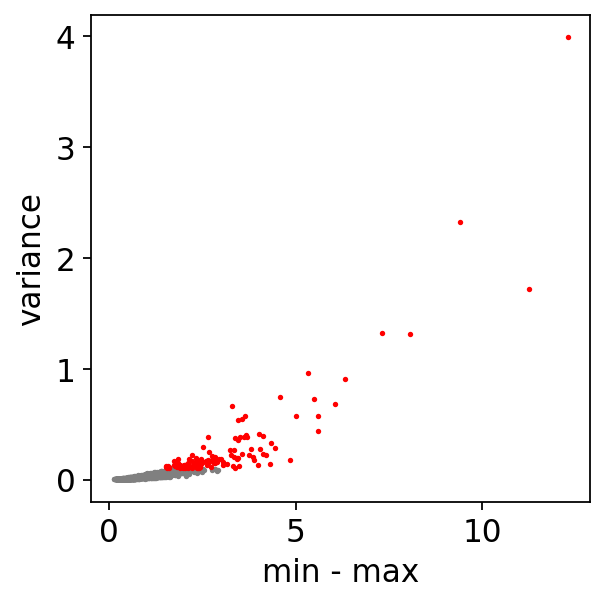

In [13]:
dynamicDf = treasmo.ds.FindPathDynamics(mudata, 
                                        ident='annotation', # ident column name to define path
                                        path=['HSC','5','7','EryP'], # list of clusters ordered by their sequence on the trajectory. A path here should have no branch
                                        range_cutoff=0.5, # filtering cutoff, max - min of correlation strength
                                        var_cutoff=0.1, # correlation strength variance cutoff
                                        pseudotime='dpt_pseudotime', # trajectory pseudotime label name in MuData.obs
                                        plot=True) # plot volcano or not

**Visualization utilities**  
Here, we pick an example and show how TREASMO can help visualize the results.

In [14]:
gene = 'ENSG00000198838'
dynamicDf['Gene'] = dynamicDf.index.str.split('~').str[0]
dynamicDf['Peak'] = dynamicDf.index.str.split('~').str[1]
peaks = dynamicDf.loc[dynamicDf['Gene']==gene]['Peak'].tolist()

**ds.PathDynamics** generates the time-bin correlation strength data and save it in MuData.uns['pathDym'][PATH_NAME][GENE]

In [15]:
mudata = treasmo.ds.PathDynamics(mudata, 
                                 gene=gene, # a single gene name
                                 peaks=peaks, # peaks in the selected pairs
                                 ident='annotation', 
                                 path=['HSC','5','7','EryP'], # PATH_NAME will be HSC-5-7-EryP in this example
                                 pseudotime='dpt_pseudotime',
                                 bins=100) # how many time bins to split the data into along the trajectory

Empty bins removed. 92 bins left


Next, we visualize the curves by **pl.PathDynamics**, the function visualizes all pairs of a given gene computated in the previous step.  
Besides the curves, it also shows the **cell proportion changes** below.

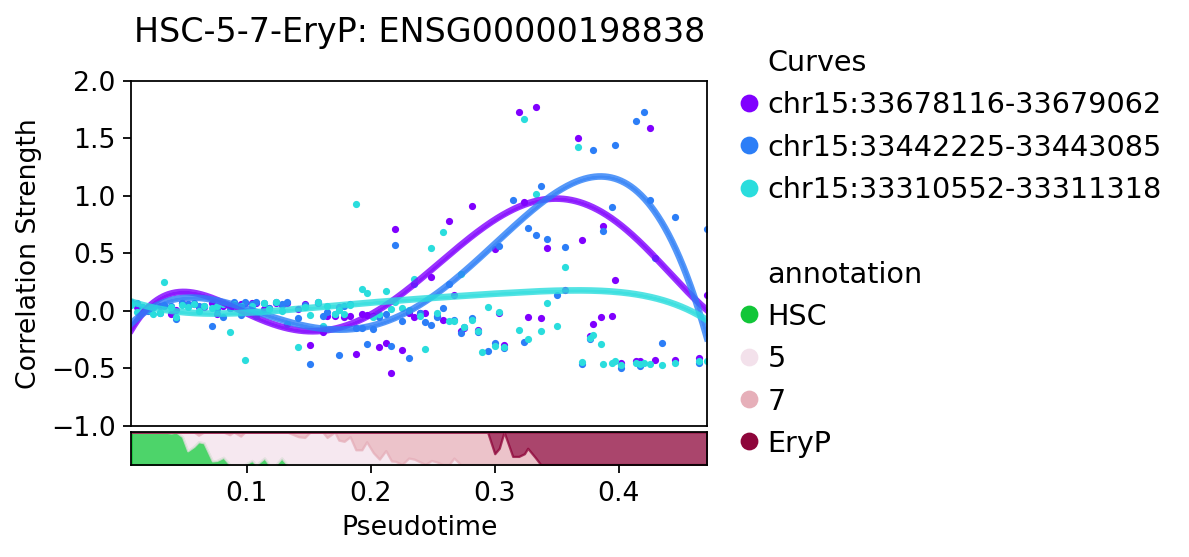

In [16]:
treasmo.pl.PathDynamics(mudata, 
                        gene=gene,
                        #xlim=(0,0.52), # xlim and ylim to set the x and y range in plot
                        ylim=(-1.0,2),
                        ident='annotation',
                        path=['HSC','5','7','EryP'])

**pl.visualize_marker** can visualize a specific marker correlation strength together with gene expression and chromatin accessibility.

ENSG00000198838 and chr15:33678116-33679062


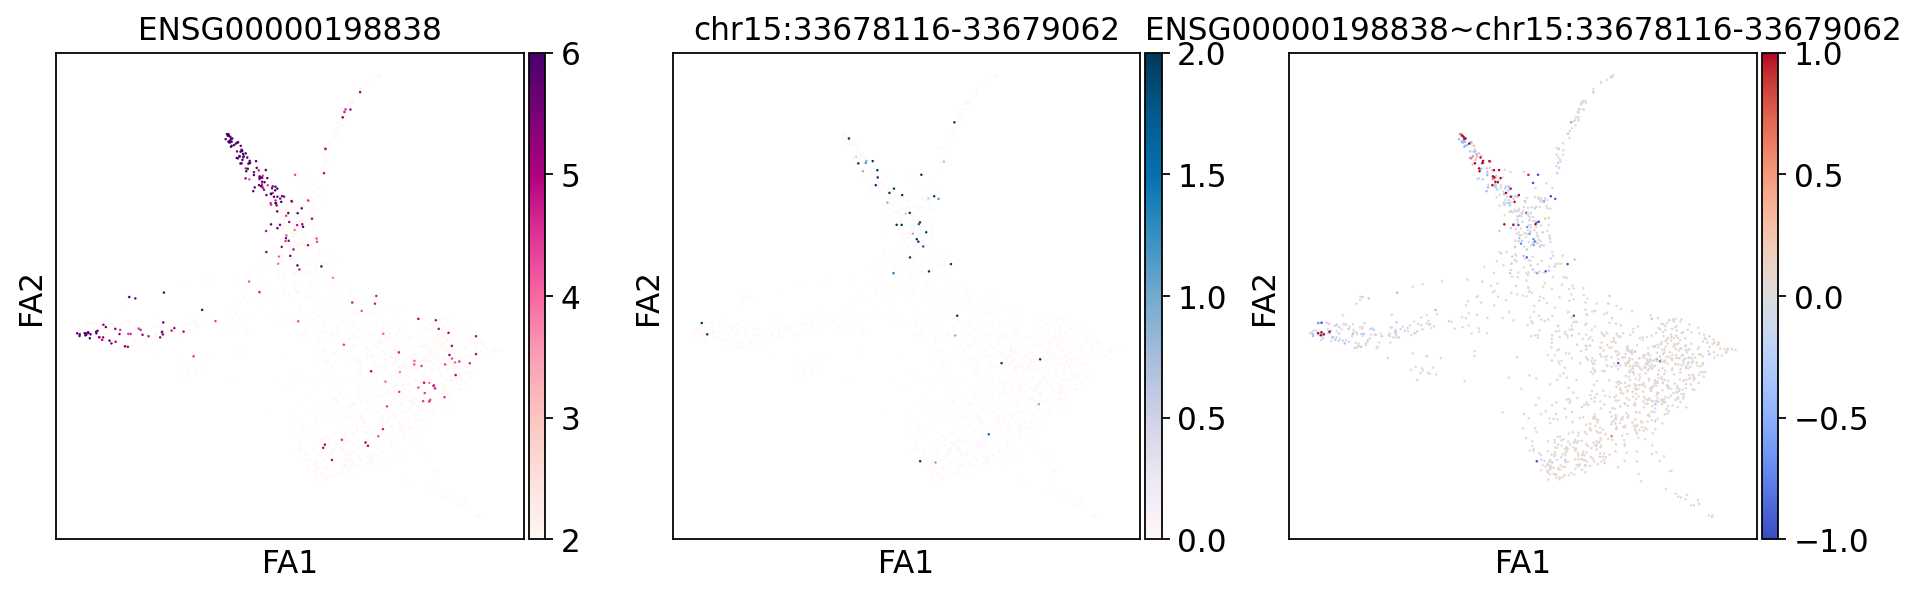

In [17]:
treasmo.pl.visualize_marker(mudata, 
                            gene=gene, # gene name
                            peak=peaks[0], # peak name, gene-peak pair must appear in uns['Local_L_names']
                            mods=['rna','atac'],
                            basis='draw_graph_fa', # on which basis/embedding to plot cells
                            cmaps=['RdPu','PuBu','coolwarm'], # colors for each of the 3 plots
                            vmins=[2,0,-1], vmaxs=[6,2,1], # value ranges for each of the 3 plots
                            size=5, # dot size
                            figsize=(14,4)) # figure size

**Analyze the relationship between different cis-regulatory elements for a gene**  
If you are interested in how are all cis-regulatory elements working together to regulate a gene's transcription, run **pl.DynamicSumMtx**.  
It summarizes the Spearman correlation between all elements.  
(ds.PathDynamics required to be done first on the gene)

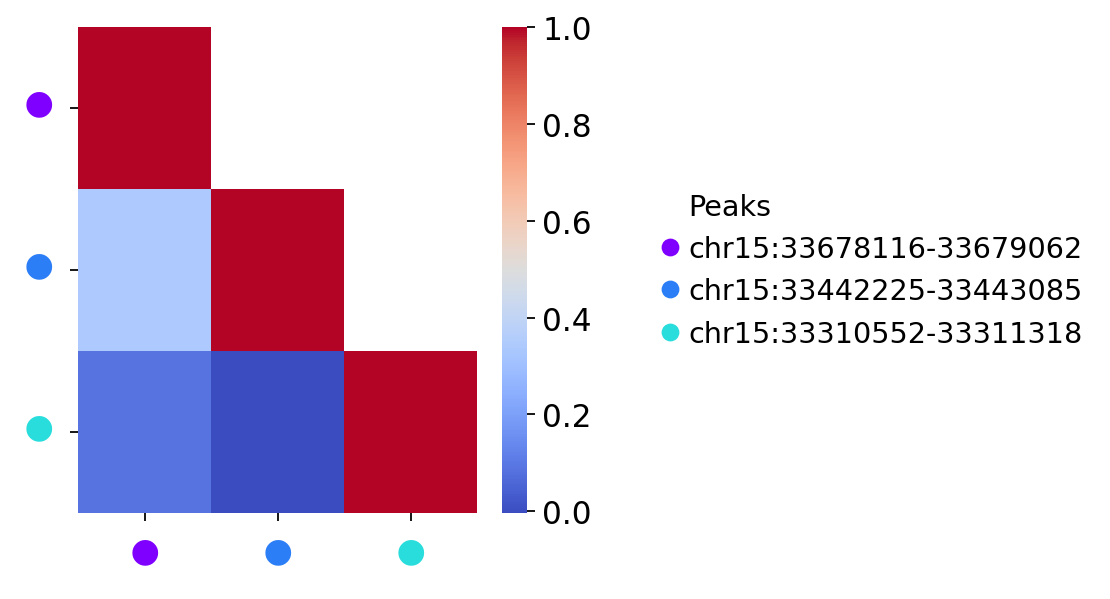

In [18]:
treasmo.pl.DynamicSumMtx(mudata, 
                        gene=gene,
                        ident='annotation',
                        path=['HSC','5','7','EryP'],
                        cmap='coolwarm')

#### 3. Discover regulatory modules along trajectory path
With all different regulatory curves, TREASMO offers a function to cluster them by temporal patterns.  
First, we run **ds.TimeBinProportion** to get cell proportion changes along the trajectory for later visualization purpose. 

In [19]:
prpDf = treasmo.ds.TimeBinProportion(mudata, ident='annotation',
                                path=['HSC','5','7','EryP'],
                                pseudotime=['dpt_pseudotime'],
                                bins=100)

Empty bins removed. 92 bins left


Next, we run **ds.DynamicModule** to discover regulatory modules. 
TREASMO uses self-organizing map (SOM) to do so. It first fits the time-bin data with Gaussian Process based regression, then clusters all curves on the fitted data.

In [20]:
somDict = treasmo.ds.DynamicModule(mudata, ident='annotation',
                                   path=['HSC','5','7','EryP'],
                                   pseudotime=['dpt_pseudotime'],
                                   bins = 100, # How many bins to divide the data along trajectory
                                   fitted = 100, # How many time points to generate the fitted data
                                   features = dynamicDf.index.to_numpy(), # features to include. The function calculates time-bin data, and no previous step is needed.
                                   num_iteration=5000, # number of iterations to optimize the SOM
                                   som_shape=(1,3), # shape of the SOM. (2,2) means we want 4 clusters, the structure is 2x2
                                   sigma=0.35, # the radius of the different neighbors in the SOM
                                   learning_rate=.1, # optimization speed
                                   random_seed=1)

Empty bins removed. 92 bins left
Start training...
 [ 5000 / 5000 ] 100% - 0:00:00 left 
 quantization error: 4.983201860730025


**Visualization**  
We can summarize all the modules found in one plot by **pl.DynamicModule** and setting ``split=False``  
The function is very general, and you can **customize every element** in the plot:  
- **(title/ticks/label)_fontsize**: fontsize of different element
- **(x/y)_label**: labels for x/y axis
- **curve_colors**: curve colors for each of the gene-peak pair correlation; if not specified, defaul color palette will be applied.
- **dot_size**: dot size in plot
- **linewidth**: curve width
- **ident_colors**: colors of each cluster to be plotted in the proportion bar. If not specified, function will look for uns[IDENT_colors] first. If not found, default color palette will be applied.
- **show_legend**: Show color legend or not
- **save**: str. if provided, heatmap will be saved in the file path

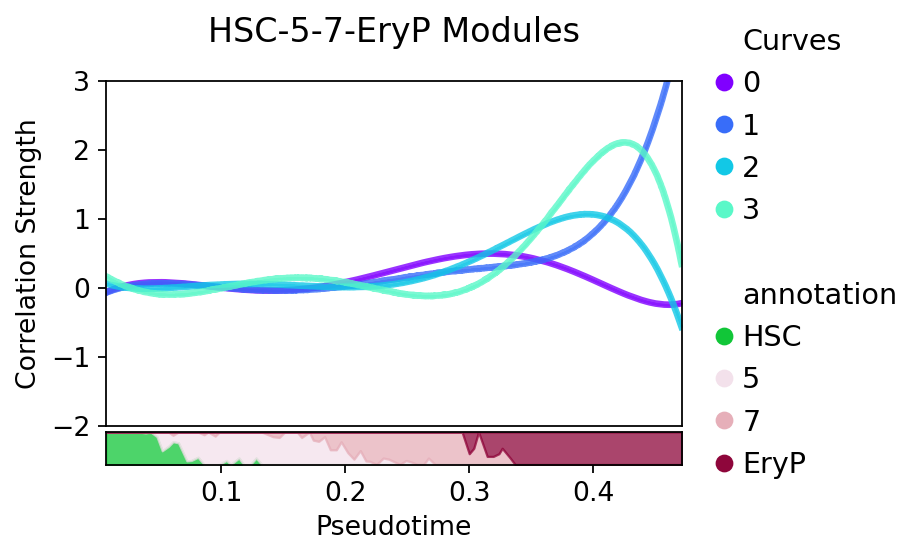

In [21]:
path = ['HSC','5','7','EryP']
treasmo.pl.DynamicModule(mudata, 
                         somDict, # ds.DynamicModule results
                         prpDf, # ds.TimeBinProportion results
                         split=False, # split by modules or not
                         #xlim=(0,0.52),
                         ylim=(-2.0,3.0))

**Or**, you can split each module by setting ``split=True``. This time, all the curves in the modules will be plotted in grey.

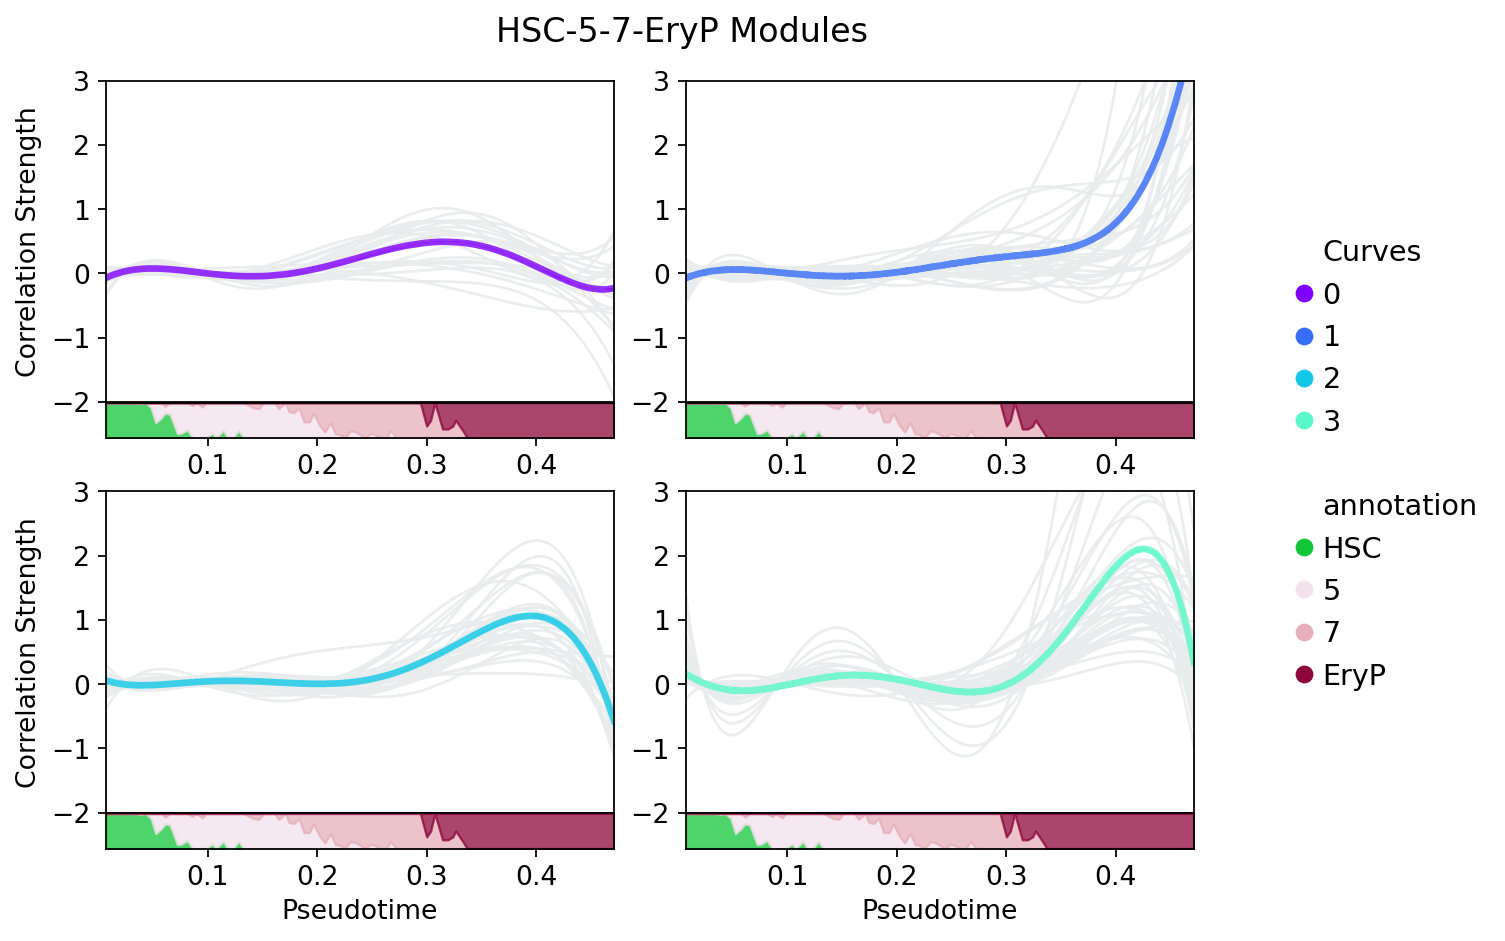

In [23]:
treasmo.pl.DynamicModule(mudata, somDict, prpDf,
                                  split=True,
                                  n_cols=2,
                                  #xlim=(0,0.52),
                                  ylim=(-2.0,3.0))